In [1]:
!pip install tensorflow opencv-python scikit-learn matplotlib numpy


[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import os
import random
import numpy as np
import tensorflow as tf
import cv2
from glob import glob
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

DATASET_DIR = "lfw-deepfunneled" 
IMG_SIZE = 128
EMBED_DIM = 128
MARGIN = 0.2
EPOCHS = 10
BATCH = 32


In [5]:
def load_image(path):
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    img = img.astype("float32") / 255.0
    return img


In [7]:
people = []
for p in os.listdir(DATASET_DIR):
    folder = os.path.join(DATASET_DIR, p)
    files = glob(os.path.join(folder, "*.jpg"))
    if len(files) >= 2:
        people.append(p)

print("People with >=2 images:", len(people))

images = []
labels = []

for label, person in enumerate(people):
    files = glob(os.path.join(DATASET_DIR, person, "*.jpg"))
    for f in files:
        images.append(f)
        labels.append(label)

print("Total images:", len(images))


People with >=2 images: 1680
Total images: 9164


In [9]:
train_files, test_files, train_labels, test_labels = train_test_split(
    images, labels, test_size=0.2, stratify=labels, random_state=42
)

print("Train size:", len(train_files))
print("Test size:", len(test_files))


Train size: 7331
Test size: 1833


In [11]:
def build_embedding():
    base = tf.keras.applications.MobileNetV2(
        include_top=False,
        input_shape=(IMG_SIZE, IMG_SIZE, 3),
        weights="imagenet"
    )
    base.trainable = False

    x = tf.keras.layers.GlobalAveragePooling2D()(base.output)
    x = tf.keras.layers.Dense(EMBED_DIM)(x)
    out = tf.keras.layers.Lambda(lambda t: tf.math.l2_normalize(t, axis=1))(x)

    return tf.keras.Model(inputs=base.input, outputs=out)

embedding_model = build_embedding()
embedding_model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 128, 128, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Conv1 (Conv2D)                │ (None, 64, 64, 32)        │             864 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ bn_Conv1 (BatchNormalization) │ (None, 64, 64, 32)        │             128 │ Conv1[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Conv1_relu (ReLU)             │ (None, 64, 64, 32)        │               0 │ bn_Conv1[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise       │ (None, 64, 64, 32)        │             288 │ Conv1_relu[0][0]           │
│ (DepthwiseConv2D)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise_BN    │ (None, 64, 64, 32)        │             128 │ expanded_conv_depthwise[0… │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise_relu  │ (None, 64, 64, 32)        │               0 │ expanded_conv_depthwise_B… │
│ (ReLU)                        │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_project         │ (None, 64, 64, 16)        │             512 │ expanded_conv_depthwise_r… │
│ (Conv2D)                      │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_project_BN      │ (None, 64, 64, 16)        │              64 │ expanded_conv_project[0][… │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand (Conv2D)       │ (None, 64, 64, 96)        │           1,536 │ expanded_conv_project_BN[… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand_BN             │ (None, 64, 64, 96)        │             384 │ block_1_expand[0][0]       │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand_relu (ReLU)    │ (None, 64, 64, 96)        │               0 │ block_1_expand_BN[0][0]    │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_pad (ZeroPadding2D)   │ (None, 65, 65, 96)        │               0 │ block_1_expand_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_depthwise             │ (None, 32, 32, 96)        │             864 │ block_1_pad[0][0]          │
│ (DepthwiseConv2D)             │                           │               

 Total params: 2,421,952 (9.24 MB)

 Trainable params: 163,968 (640.50 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [13]:
def triplet_loss(a,p,n, margin=MARGIN):
    ap = tf.reduce_sum(tf.square(a - p), axis=1)
    an = tf.reduce_sum(tf.square(a - n), axis=1)
    loss = tf.maximum(ap - an + margin, 0.0)
    return tf.reduce_mean(loss)


In [15]:
def sample_triplet_batch(files, labels, batch_size=32):
    anchors = []
    positives = []
    negatives = []

    label_set = list(set(labels))
    
    while len(anchors) < batch_size:
        pos_label = random.choice(label_set)
        neg_label = random.choice([l for l in label_set if l != pos_label])

        pos_files = [f for f,l in zip(files,labels) if l == pos_label]
        neg_files = [f for f,l in zip(files,labels) if l == neg_label]

        if len(pos_files) < 2:
            continue

        a,p = random.sample(pos_files, 2)
        n = random.choice(neg_files)

        anchors.append(load_image(a))
        positives.append(load_image(p))
        negatives.append(load_image(n))

    return (
        np.array(anchors),
        np.array(positives),
        np.array(negatives)
    )


In [17]:
optimizer = tf.keras.optimizers.Adam(1e-4)

for epoch in range(EPOCHS):
    a,p,n = sample_triplet_batch(train_files, train_labels, BATCH)

    with tf.GradientTape() as tape:
        ea = embedding_model(a)
        ep = embedding_model(p)
        en = embedding_model(n)

        loss = triplet_loss(ea,ep,en)

    grads = tape.gradient(loss, embedding_model.trainable_variables)
    optimizer.apply_gradients(zip(grads, embedding_model.trainable_variables))

    print(f"Epoch {epoch+1}/{EPOCHS}  Loss = {loss.numpy():.4f}")


Epoch 1/10  Loss = 0.0914
Epoch 2/10  Loss = 0.1562
Epoch 3/10  Loss = 0.1304
Epoch 4/10  Loss = 0.1081
Epoch 5/10  Loss = 0.1345
Epoch 6/10  Loss = 0.0954
Epoch 7/10  Loss = 0.0618
Epoch 8/10  Loss = 0.1200
Epoch 9/10  Loss = 0.0697
Epoch 10/10  Loss = 0.1117


In [19]:
os.makedirs("models", exist_ok=True)
embedding_model.save("models/face_siamese.h5")
print("Model saved!")


Model saved!


Valid identities in training with >=2 images: 1582
Filtered train size: 7233


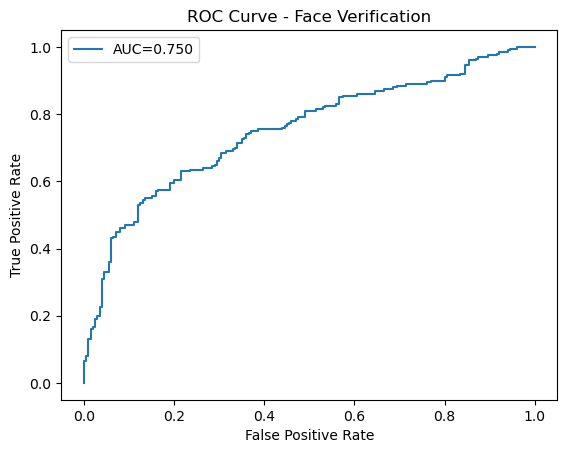

AUC = 0.7503


In [23]:
from collections import Counter
from sklearn.metrics import roc_curve, auc
import random
import numpy as np
import matplotlib.pyplot as plt

# ---------- FILTER TRAIN SET TO LABELS WITH >=2 IMAGES ----------
label_counts = Counter(train_labels)

valid_labels = [lbl for lbl,count in label_counts.items() if count >= 2]

print("Valid identities in training with >=2 images:", len(valid_labels))

filtered_train_files = []
filtered_train_labels = []

for f,l in zip(train_files, train_labels):
    if l in valid_labels:
        filtered_train_files.append(f)
        filtered_train_labels.append(l)

print("Filtered train size:", len(filtered_train_files))


# ---------- EMBEDDING HELPER ----------
def embed(path):
    return embedding_model(np.expand_dims(load_image(path),0))


# ---------- BUILD PAIRS ----------
y_true = []
scores = []

for i in range(400):  # number of test pairs
    same = random.choice([0,1])

    # SAME PERSON PAIR
    if same:
        lbl = random.choice(valid_labels)
        files = [f for f,l in zip(filtered_train_files,filtered_train_labels) if l==lbl]
        f1,f2 = random.sample(files,2)
        y_true.append(1)

    # DIFFERENT PERSON PAIR
    else:
        lbl1,lbl2 = random.sample(valid_labels,2)
        
        f1 = random.choice([f for f,l in zip(filtered_train_files,filtered_train_labels) if l==lbl1])
        f2 = random.choice([f for f,l in zip(filtered_train_files,filtered_train_labels) if l==lbl2])

        y_true.append(0)

    e1 = embed(f1)
    e2 = embed(f2)

    dist = np.sum((e1-e2)**2)
    scores.append(-dist)


# ---------- ROC ----------
fpr,tpr,_ = roc_curve(y_true, scores)
roc_auc = auc(fpr,tpr)

plt.plot(fpr,tpr,label=f"AUC={roc_auc:.3f}")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.title("ROC Curve - Face Verification")
plt.show()

print("AUC =", roc_auc)
